# Analyzing Negative Temperature Intervals

In this notebook, we seek to:
1. Identify the duration that the internal temp. of the compressor is below 0°C.
2. Determine the frequency that the internal temp. measures below 0°C.
3. Explore causes for the gap in actual and requested temp. and why the internal temp. measures below 0°C.

### Data Loading & Preprocessing

In [1]:
import pandas as pd

**Raw Data**

In [121]:
pivotted = pd.read_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_finaltripflags.csv')
pivotted['cvdcus_timestamp_s_3'] = pd.to_datetime(pivotted['cvdcus_timestamp_s_3'])
pivotted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183491 entries, 0 to 183490
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   cvdcus_timestamp_s_3   183491 non-null  datetime64[ns]
 1   epoch                  183491 non-null  float64       
 2   epoch_diff             183490 non-null  float64       
 3   trip                   183491 non-null  int64         
 4   BrkTot_Tq_Actl         176228 non-null  float64       
 5   HvacBlwrFront_D_Stat   31228 non-null   object        
 6   Veh_V_ActlEng          169285 non-null  float64       
 7   GearLvrPos_D_Actl      169864 non-null  object        
 8   ApedPos_Pc_ActlArb     177919 non-null  float64       
 9   EngAout_N_Actl         177919 non-null  float64       
 10  HvacEvap_Te_Actl       128521 non-null  float64       
 11  HvacEvap_Te_Rq         128521 non-null  float64       
 12  HvacAirCond_B_Rq       128521 non-null  obje

**Imputed Data**

In [122]:
pivotted_f = pd.read_csv(r'C:\Users\achopra8\Documents\BDD Climate Control\2019f150VIN1FTEW1C53KFB01079_pivotted_finaltripflags_imputed.csv')
pivotted_f['cvdcus_timestamp_s_3'] = pd.to_datetime(pivotted_f['cvdcus_timestamp_s_3'])
pivotted_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157856 entries, 0 to 157855
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   cvdcus_timestamp_s_3   157856 non-null  datetime64[ns]
 1   epoch                  157856 non-null  float64       
 2   epoch_diff             157855 non-null  float64       
 3   trip                   157856 non-null  int64         
 4   BrkTot_Tq_Actl         157856 non-null  float64       
 5   Veh_V_ActlEng          157856 non-null  float64       
 6   ApedPos_Pc_ActlArb     157856 non-null  float64       
 7   EngAout_N_Actl         157856 non-null  float64       
 8   HvacEvap_Te_Actl       157856 non-null  float64       
 9   HvacEvap_Te_Rq         157856 non-null  float64       
 10  BattULo_U_Actl         157856 non-null  float64       
 11  AirCondFluidHi_P_Actl  157856 non-null  float64       
 12  AirAmb_Te_ActlFilt     157856 non-null  floa

We can drop "HvacAirCond_B_Rq" since data was already preprocessed to ensure AC is on for all trips.

In [123]:
pivotted = pivotted.drop('HvacAirCond_B_Rq', axis=1)
pivotted_f = pivotted_f.drop('HvacAirCond_B_Rq', axis=1)

Now let's map actual temperature values to signs (negative = -1, positive = 1, zero = 0). This will allow us to extract all negative temperature intervals.

In [194]:
import numpy as np

def map_temp_to_sign_get_intervals(pivotted, upper_bound_temp):
    pivotted['HvacEvap_Te_Actl_sign'] = pivotted_f['HvacEvap_Te_Actl'].map(lambda x: -1 if 0 <= x <= upper_bound_temp else np.sign(x)) # col to keep track of sign

    neg_temp_intervals = []
    for trip in pivotted['trip'].unique():
        temp = pivotted[pivotted['trip'] == trip]
        for i, g in temp.groupby([(pivotted['HvacEvap_Te_Actl_sign'] != pivotted['HvacEvap_Te_Actl_sign'].shift()).cumsum()]):
            if g.loc[g.index[0], 'HvacEvap_Te_Actl_sign'] == -1:
                neg_temp_intervals.append(g)
    neg_temp_intervals.sort(key=lambda x: x['epoch'].max() - x['epoch'].min())
    return neg_temp_intervals

neg_temp_intervals_raw = map_temp_to_sign_get_intervals(pivotted, 0)
neg_temp_intervals_imputed = map_temp_to_sign_get_intervals(pivotted_f, 0)

### Descriptive Statistics

In [195]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import describe

DescribeResult(nobs=58, minmax=(0.0, 31.0), mean=4.344827586206897, variance=19.14216575922565, skewness=4.041657981665437, kurtosis=22.035436527371125)


Text(0, 0.5, 'Density')

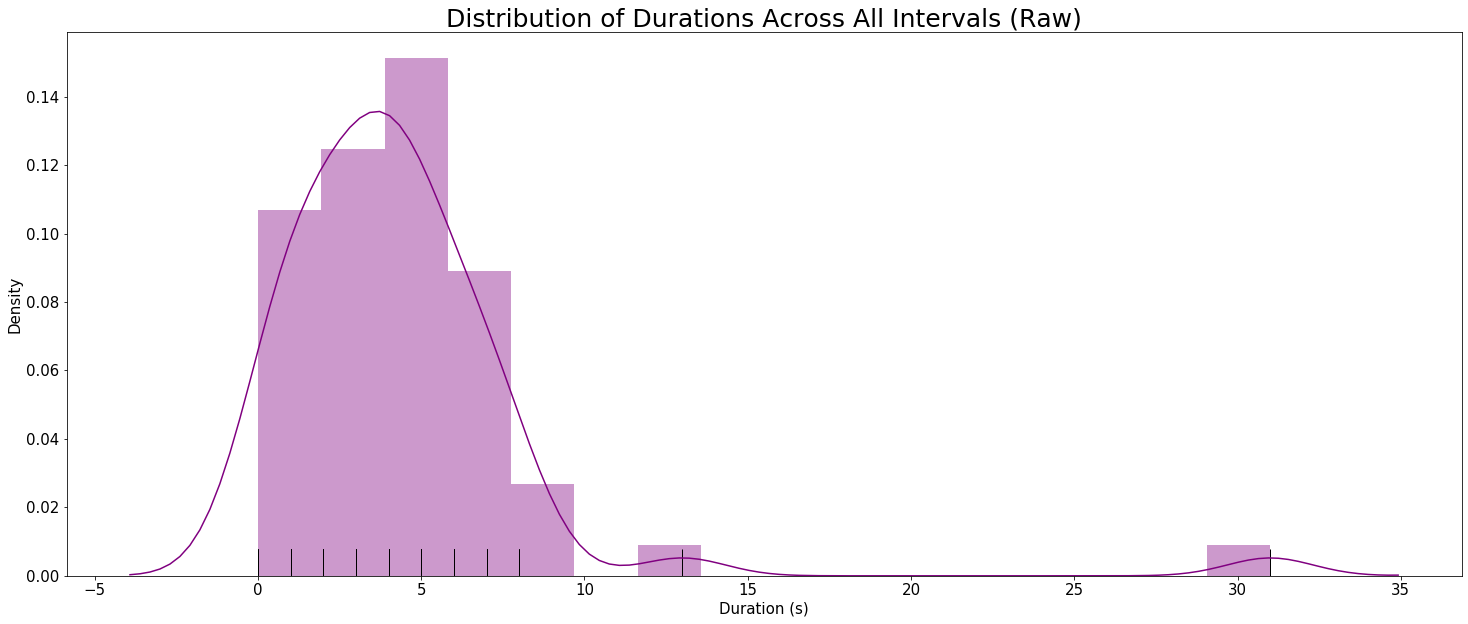

In [196]:
time_elap_raw = [interval['epoch'].max() - interval['epoch'].min() for interval in neg_temp_intervals_raw]
print(describe(time_elap_raw))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap_raw, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Durations Across All Intervals (Raw)', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Duration (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

DescribeResult(nobs=58, minmax=(0.0, 31.0), mean=4.344827586206897, variance=19.14216575922565, skewness=4.041657981665437, kurtosis=22.035436527371125)


Text(0, 0.5, 'Density')

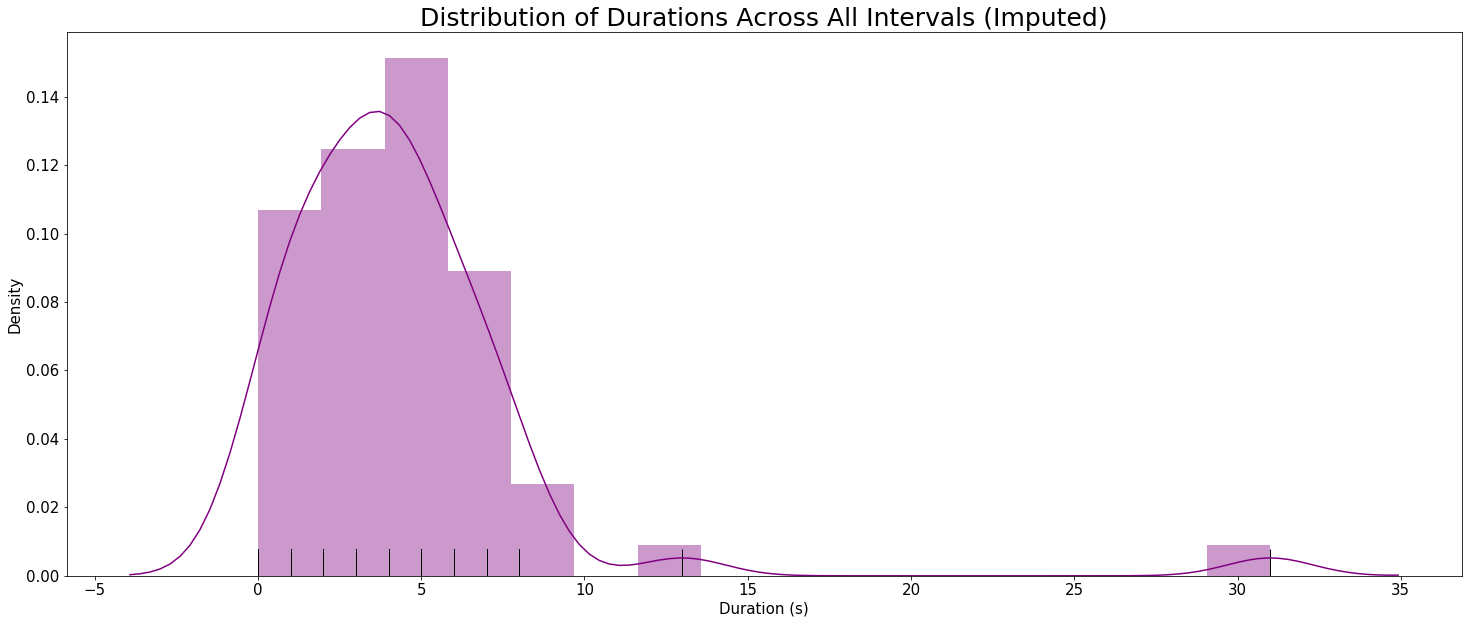

In [197]:
time_elap_imputed = [interval['epoch'].max() - interval['epoch'].min() for interval in neg_temp_intervals_imputed]
print(describe(time_elap_imputed))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap_imputed, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Durations Across All Intervals (Imputed)', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Duration (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

There doesn't seem to be much of a statistical difference between the distributions whether or not the data is imputed. Going forward, we will use the imputed data.

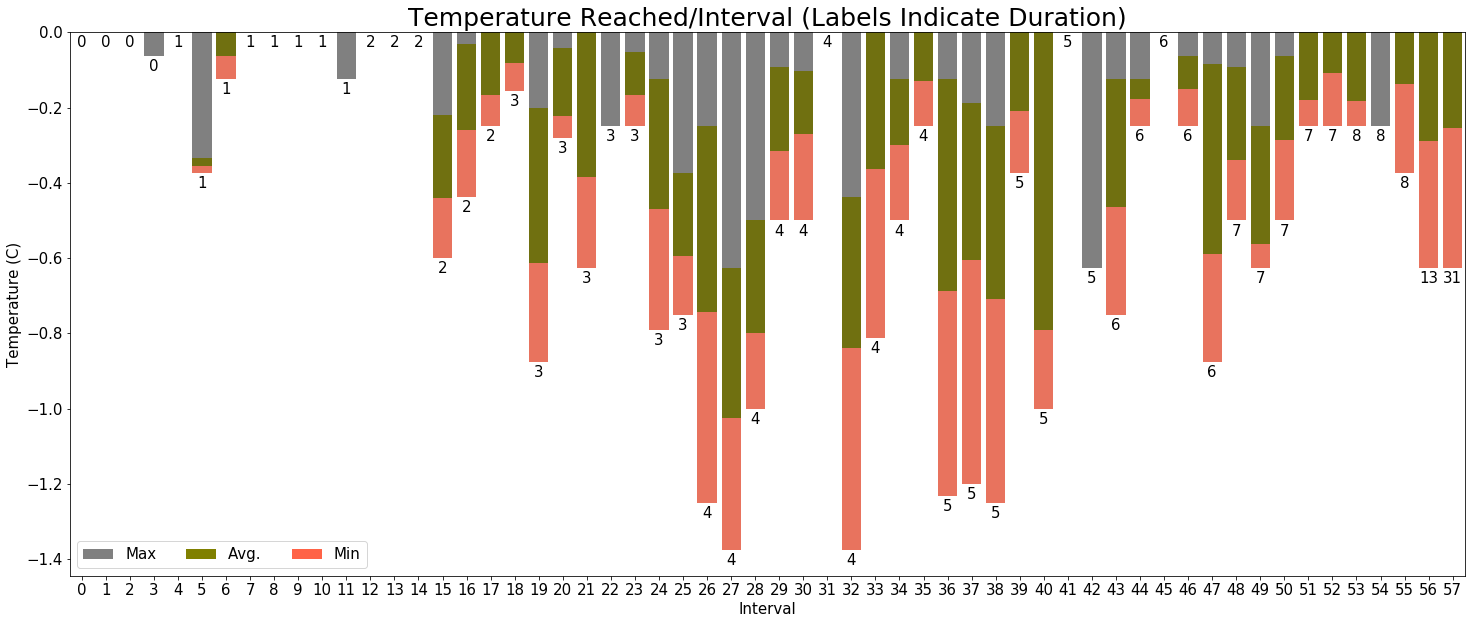

In [236]:
# function to make color gradient based on values
# def colors_from_values(values, palette_name):
#     # normalize the values to range [0, 1]
#     normalized = (values - min(values)) / (max(values) - min(values))
#     # convert to indices
#     indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
#     # use the indices to get the colors
#     palette = sns.color_palette(palette_name, len(values))
#     return np.array(palette).take(indices, axis=0)

fig, ax = plt.subplots(figsize=(25, 10))
min_temps = [interval['HvacEvap_Te_Actl'].min() for interval in neg_temp_intervals_imputed]
avg_temps = [interval['HvacEvap_Te_Actl'].mean() for interval in neg_temp_intervals_imputed]
max_temps = [interval['HvacEvap_Te_Actl'].max() for interval in neg_temp_intervals_imputed]
sns.barplot(x=[str(i) for i in range(len(neg_temp_intervals_imputed))], y=min_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='tomato')
sns.barplot(x=[str(i) for i in range(len(neg_temp_intervals_imputed))], y=avg_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='olive')
g = sns.barplot(x=[str(i) for i in range(len(neg_temp_intervals_imputed))], y=max_temps, order=[str(i) for i in range(len(neg_temp_intervals_imputed))], color='grey')
plt.title('Temperature Reached/Interval (Labels Indicate Duration)', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Interval', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Temperature (C)', fontsize=15)
leg_colors = [plt.Rectangle((0,0),1,1,fc='grey'), plt.Rectangle((0,0),1,1,fc='olive'), plt.Rectangle((0,0),1,1,fc="tomato")]
plt.legend(leg_colors, ['Max', 'Avg.', 'Min'], ncol = 3, prop={'size':15})

for interval, temp, duration in zip(range(len(neg_temp_intervals_imputed)), min_temps, time_elap_imputed):
    g.text(interval, temp - 0.04, round(duration), color='black', ha="center", fontsize=15)

Text(0, 0.5, 'Temperature (C)')

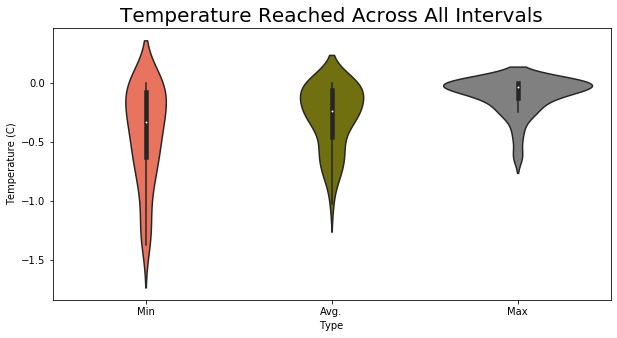

In [215]:
fig, ax = plt.subplots(figsize=(10, 5))
pal = {'Min':'tomato', 'Avg.':'olive', 'Max':'grey'}
sns.violinplot(x='variable', y='value', data=pd.melt(pd.DataFrame({'Min':min_temps, 'Avg.':avg_temps, 'Max':max_temps})), palette=pal)
plt.title('Temperature Reached Across All Intervals', fontsize=20)
plt.xticks(fontsize=10)
plt.xlabel('Type', fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel('Temperature (C)', fontsize=10)



DescribeResult(nobs=45, minmax=(8.0, 1558336.0), mean=161295.7111111111, variance=106400119067.8919, skewness=2.765758494399264, kurtosis=7.526989707164141)


Text(0, 0.5, 'Density')

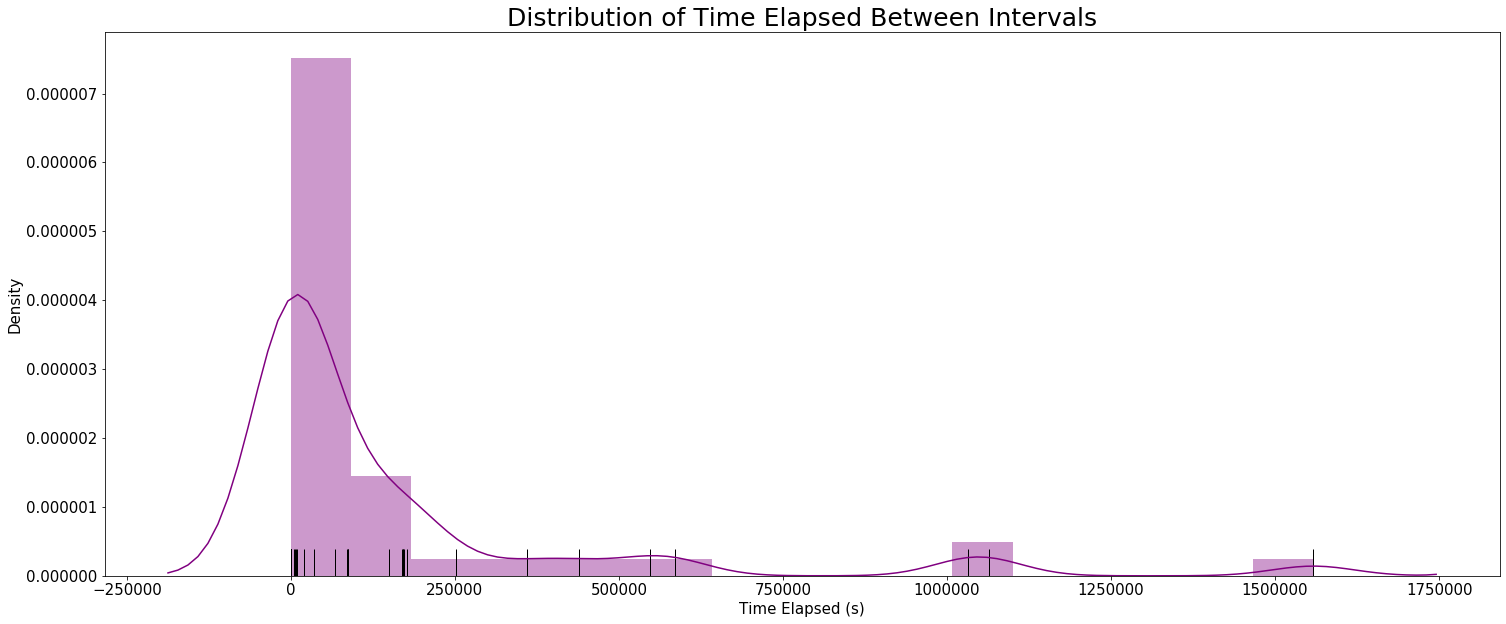

In [106]:
time_elap_between_intervals = np.diff(sorted([pivotted_f['epoch'].min()] + [interval['epoch'].iloc[0] for interval in neg_temp_intervals_imputed]))
print(describe(time_elap_between_intervals))
fig, ax = plt.subplots(figsize=(25, 10))
sns.distplot(time_elap_between_intervals, color='Purple', rug=True, rug_kws={"color": "black"})
plt.title('Distribution of Time Elapsed Between Intervals', fontsize=25)
plt.xticks(fontsize=15)
plt.xlabel('Time Elapsed (s)', fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Density', fontsize=15)

In [127]:
print(pivotted_f['cvdcus_timestamp_s_3'].min())
print(pivotted_f['cvdcus_timestamp_s_3'].max())

2019-05-01 14:40:10
2019-07-26 03:05:17


Over the span of summer 2019 (May - July), the actual temperature is below 0°C every 161296 seconds (1.8 days) on average.

Let's look closer at how the other signals are changing during these intervals. Interval 57 looks particularily concerning, as it lasts the longest (31 seconds) and reaches a minimum temperature of -0.6.

In [239]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_interval(interval=range(len(neg_temp_intervals_imputed))):
    display(neg_temp_intervals_imputed[interval])

interactive(children=(Dropdown(description='interval', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

In [250]:
@interact
def generate_heatmap(save_fig=widgets.Checkbox(value=False, description='Save Plot'), interval=range(len(neg_temp_intervals_imputed))):
    interval = neg_temp_intervals_imputed[interval]
    f, ax = plt.subplots(figsize=(14, 12)) 
    try:
        heatmap = sns.heatmap(pd.get_dummies(interval[['epoch'] + list(interval.columns[4:-1])]).corr(), annot=True, linewidths=0.5)
    except ValueError:
        print('Cannot produce heatmap since interval only lasts for 1 second!')
        plt.close()
    else:
        if save_fig:
            try:
                fig.savefig('neg_temp_intervals/heatmaps/Trip{}.png'.format(interval['trip'].iloc[0]))
            except FileNotFoundError:
                print("Directory doesn't exists! Make directory called 'neg_temp_intervals/heatmaps'")
        return heatmap

interactive(children=(Checkbox(value=False, description='Save Plot'), Dropdown(description='interval', options…